## Importing

In [1]:
### libraries use
# ! pip install scikit-plot
# ! pip install imblearn
# !pip install xgboost

In [2]:
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib as mpl

# models and metrics
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import confusion_matrix, classification_report, precision_score, recall_score, roc_auc_score
from scikitplot.metrics import plot_confusion_matrix, plot_roc, plot_precision_recall
from scikitplot.estimators import plot_feature_importances

# to load saved data
import pickle
import os

from customized_packages.customized_functions import load_prepared_data, evaluate_model

In [3]:
import warnings
warnings.filterwarnings("ignore")

## Load prepared data

In [4]:
# Load pre-processed data
X_train, X_test, y_train, y_test, feature_names = load_prepared_data()

## Build model

### Random Forrest with imbalanced data

In [5]:
# Random forrest classifier to train imbalanced data
clf = RandomForestClassifier()
clf.fit(X_train, y_train)
# y_pred_imbalanced = clf.predict(X_test)
# y_prob_imbalanced = clf.predict_proba(X_test)

RandomForestClassifier()

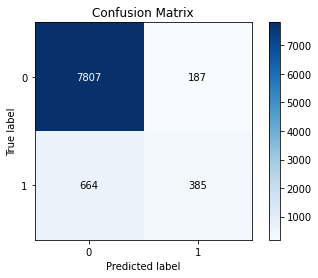

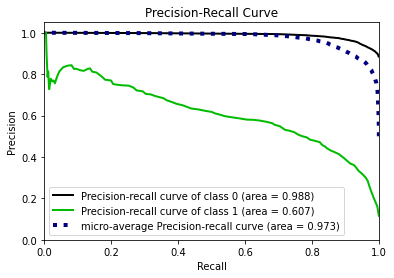

Precision Score:  0.67
Recall Score:  0.37


In [6]:
evaluate_model(clf, X_test, y_test)

### Synthetic minority oversampling (SMOTE)

In [7]:
from imblearn import over_sampling

def oversampling_by_SMOTE(X_train, y_train, ratio_with_majority_class=0.85, k=5):
    """ Synthetic new training for minority group using SMOTE technique
    
    Parameters
    ----------
    X_train : numpy array
        training features
    y_train : numpy array
        training labels
    ratio_with_majority_class: int (optional)
        ratio of majority and minority after oversampling
    k :  int (optional)
        number of KNN neighbors
    Returns
    -------
    X_train_smote : numpy array
        oversampled training features
    y_train_smote : numpy array
        oversampled labels
    """
    
    # Size of minority and majority classes
    majority_class_size = len(y_train[y_train == 0])
    minority_class_size = len(y_train[y_train == 1])
    
    # Define a balancer
    balancer = int(ratio_with_majority_class * majority_class_size)
    
    # Creating the strategy for oversampling
    strategy_smote = {0: majority_class_size, 1: balancer}
    
    # Oversampling
    oversampler = over_sampling.SMOTE(sampling_strategy=strategy_smote, random_state=10, k_neighbors=k)
    X_train_smote, y_train_smote = oversampler.fit_resample(X_train, y_train)
    
    return X_train_smote, y_train_smote

In [8]:
# Synthetic new training samples
X_train_smote, y_train_smote = oversampling_by_SMOTE(X_train, y_train)

# Check the size after apply SMOTE
unique, counts_smote = np.unique(y_train_smote, return_counts=True)
dict(zip(unique, counts_smote))

{0: 31928, 1: 27138}

### Random forrest with SMOTE

In [9]:
# Build Random Forest model for synthetic data
clf_smote = RandomForestClassifier()
# Assign the above probabilities to the corresponding class ('no', 'yes')
clf_smote.fit(X_train_smote, y_train_smote)

RandomForestClassifier()

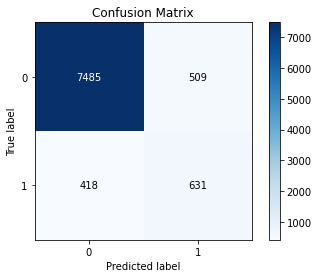

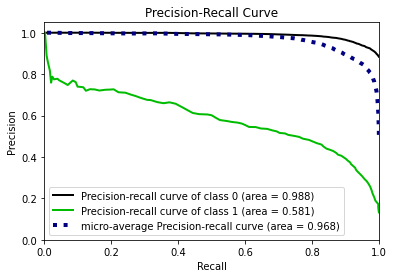

Precision Score:  0.55
Recall Score:  0.6


In [10]:
evaluate_model(clf_smote, X_test, y_test)

### Parameters tunning for random forrest

In [11]:
from sklearn.model_selection import RandomizedSearchCV

> Best estimators using RandomizedSearchCV: 
> RandomForestClassifier(bootstrap=False, 
                        max_depth=80, 
                        min_samples_leaf=20,
                        min_samples_split=25, 
                        n_estimators=400)

In [12]:
from sklearn.model_selection import GridSearchCV

In [13]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 600, num = 5)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(60, 100, num = 5)]

# Minimum number of samples required to split a node
min_samples_split = [15, 20, 25]

# Minimum number of samples required at each leaf node
min_samples_leaf = [15, 20, 25, 30, 35]

# # Method of selecting samples for training each tree
bootstrap = [False]

#Create the random grid
param_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [14]:
# Tune the model by finding the best hyperparameters
clf_grid_search = GridSearchCV(estimator=clf_smote,
                              param_grid=param_grid,
                              cv=3,
                              n_jobs=-1,
                              verbose=2)
# Fit the Random Forest model based on the best parameters
clf_grid_search.fit(X_train_smote, y_train_smote)
clf_grid_search.best_estimator_

Fitting 3 folds for each of 750 candidates, totalling 2250 fits
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=15, min_samples_split=15, n_estimators=400; total time=  37.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=15, min_samples_split=15, n_estimators=600; total time= 1.1min
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=15, min_samples_split=20, n_estimators=500; total time=  50.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=300; total time=  27.7s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=500; total time=  43.9s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=20, min_samples_split=15, n_estimators=400; total time=  35.5s
[CV] END bootstrap=False, max_depth=60, max_features=auto, min_samples_leaf=20, min_samples_split=15, 

RandomForestClassifier(bootstrap=False, max_depth=90, max_features='sqrt',
                       min_samples_leaf=15, min_samples_split=25,
                       n_estimators=600)

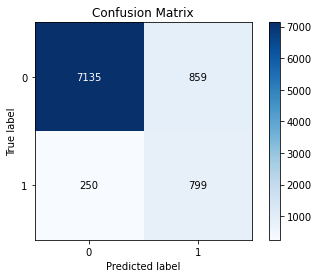

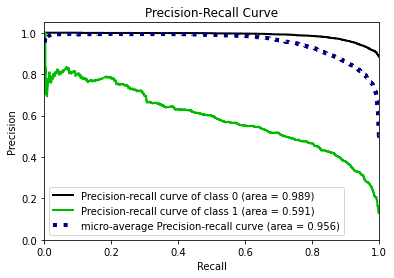

Precision Score:  0.48
Recall Score:  0.76


In [15]:
evaluate_model(clf_grid_search.best_estimator_, X_test, y_test)

## XGBoost

In [16]:
import xgboost as xgb

In [17]:
boost = xgb.XGBClassifier(learning_rate = 0.01,
                          max_depth = 10, 
                          n_estimators = 1000,
                          use_label_encoder=False)
boost.fit(X_train_smote, y_train_smote, eval_metric="auc", eval_set = [(X_test, y_test)], verbose = 0)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.01, max_delta_step=0,
              max_depth=10, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=1000, n_jobs=8,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', use_label_encoder=False,
              validate_parameters=1, verbosity=None)

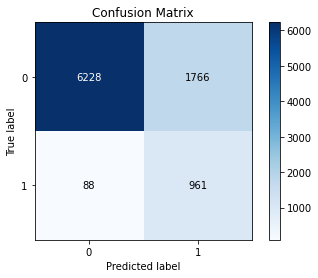

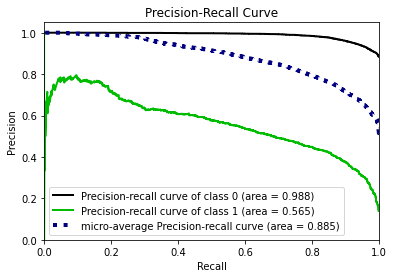

Precision Score:  0.35
Recall Score:  0.92


In [18]:
evaluate_model(boost, X_test, y_test)

## Save the best model

In [19]:
# create an iterator object with write permission - model.pkl
with open('model_pkl', 'wb') as file:
    pickle.dump(clf_grid_search.best_estimator_, file)

[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=300; total time=  29.3s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=15, min_samples_split=25, n_estimators=500; total time=  46.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=20, min_samples_split=15, n_estimators=300; total time=  27.2s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=20, min_samples_split=15, n_estimators=600; total time=  54.6s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=20, min_samples_split=20, n_estimators=400; total time=  36.7s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=200; total time=  18.4s
[CV] END bootstrap=False, max_depth=80, max_features=auto, min_samples_leaf=20, min_samples_split=25, n_estimators=300; total time=  27.5s
[CV] END bootstrap=False, m